<h3>Data Collection</h3>
We have collected January 2019 and February 2019 Yellow Taxi trips data from <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page">New York TLC</a>, consisting of 19 features each.

<h3> ML Problem Formulation</h3>
Our main objective is to find the frequency of pickups for a given division.

In [0]:
pip install prettytable

Python interpreter will be restarted.
Collecting prettytable
 Downloading prettytable-3.3.0-py3-none-any.whl (26 kB)
Requirement already satisfied: wcwidth in /databricks/python3/lib/python3.8/site-packages (from prettytable) (0.2.5)
Installing collected packages: prettytable
Successfully installed prettytable-3.3.0
Python interpreter will be restarted.

In [0]:
from prettytable import PrettyTable
import numpy as np
import pandas as pd
from pyspark.sql import functions as F

from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import DoubleType
from pyspark.sql.types import *
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

<h2> Import Data

In [0]:
def import_data(filepaths):
  """
  Import Data from list of filepaths and concatanate 
  """
  df = spark.read.csv(filepaths[0],header=True)
  for path in filepaths[1:]:
    df = df.unionByName(spark.read.csv(path,header=True))
  return df


# Import Data
taxi = import_data(["/mnt/pirates-of-the-carribbytes/taxi_data/taxi_2019-01.csv",
                    "/mnt/pirates-of-the-carribbytes/taxi_data/taxi_2019-02.csv",
                    "/mnt/pirates-of-the-carribbytes/taxi_data/taxi_2019-03.csv"])


# Import Zone data and join with our dataset. Remove datapoints from EWR and Staten Island
zones = spark.read.csv("/mnt/pirates-of-the-carribbytes/taxi_data/zone_lookup.csv",header=True).drop("Zone","service_zone")
taxi = taxi.join(zones,taxi.PULocationID == zones.LocationID)\
                 .withColumnRenamed("Borough","Division")\
                 .filter((F.col('Division') != 'EWR') & (F.col('Division') != 'Staten Island'))

# Filter to ensure no outlier years are included (we found a timestamp of 2088) and remove unnecessary columns
taxi = taxi.filter((F.unix_timestamp(taxi.tpep_pickup_datetime)>=1546300800) & (F.unix_timestamp(taxi.tpep_pickup_datetime)<=1554073200))\
           .drop('VendorID', 'RatecodeID', 'store_and_fwd_flag','DOLocationID','fare_amount','extra',"LocationID","PULocationID",
                 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'payment_type')



divs = ["Manhattan", "Queens", "Bronx","Brooklyn", "Unknown"]

<h2> Data Cleaning & Preprocessing </h2>

In [0]:
def remove_outliers(df):
  """
  This function preprocesses our data,
  removes unnecessary outliers and
  creates 10 min time bins
  """
  
  # Create Pickup and Dropoff UNIX time from datetime feature
  df = df.select("*", F.unix_timestamp(df.tpep_pickup_datetime).alias('Pickup_Unix'),
                      F.unix_timestamp(df.tpep_dropoff_datetime).alias('Dropoff_Unix'))
  
  #Changing the datatype in numerical columns to double
  tcols = ['passenger_count', 'trip_distance', 'total_amount']
  for c in tcols:
    # add condition for the cols to be type cast
    df = df.withColumn(c, df[c].cast('double'))
  
  # Create Duration and Speed columns, remove Dropoff_Unix, datetime of pickup and dropoff
  df = df.withColumn("Duration", F.round((df['Dropoff_Unix'] - df['Pickup_Unix'])/60,2))\
                        .withColumn("Speed", F.round(60*(df['trip_distance'] / ((df['Dropoff_Unix']-df['Pickup_Unix'])/60)),2))\
                        .drop("Dropoff_Unix","tpep_dropoff_datetime","tpep_pickup_datetime")
  
  
  #Filter Outliers, Add Time Bin
  df = df.where((df['Duration']>=1) & (df['Duration']<=180))\
         .where((df['Speed']>0) & (df['Speed']<=60))\
         .where((df['trip_distance']>0) & (df['trip_distance']<=35))\
         .where((df['total_amount']>=2.5) & (df['total_amount']<=150))\
         .filter((F.isnull(df['passenger_count'])==False) & (df['passenger_count']>0))\
         .withColumn("BIN",((df.Pickup_Unix - 1546300800)/1800).cast("int")).withColumn("COUNT",F.lit(1))

  # Group By Time Bins and Divisions and get final dataset
  df = df.groupBy(["BIN","Division"])\
         .agg(F.mean("Duration"),F.mean("Speed"),F.mean("trip_distance"),F.mean("total_amount"),F.sum("COUNT"))\
         .sort("BIN")\
         .drop("BIN")

  return df


taxi_clean = remove_outliers(taxi).cache()

<h3> Defining Required Functions

In [0]:
def custom_partitioner(key):
  """
  Custom Partitioner to parallelise
  data based on Division
  """
  if key=="Manhattan":
    return 1
  elif key=="Queens":
    return 2
  elif key=="Bronx":
    return 3
  elif key=="Brooklyn":
    return 4
  else:
    return 5


def toPandas_partition(instances):
  """
  Create Dataframes for each instance 
  to be used as input for VAR model
  """
  
  import pandas as pd
  
  panda_df = pd.DataFrame(columns = columns)
  
  for instance in instances:
    panda_df= panda_df.append(instance.asDict(), ignore_index=True)
  panda_df = panda_df
  return [panda_df]

In [0]:
def findlags_map(df):
  """
  HyperParameter Tuning to find best lag
  for specific dataframe
  """
  # Hyper Parameter
  lags = [144,192,240,336,672,1008,1344,1680]
  
  # Initialise minimum MAPE to 100000
  minMape = 100000
  numLags = 0
  
  nobs = round(0.1*len(df))
  df_train = df[0:-nobs]
  df_val = df[-nobs:]
  df_val = df_val.reset_index()
  
  # For each lag value
  for i in lags:
    
    # Define Model
    model = VAR(df_train)
    
    # Fit and specify Lag order for predictions
    model_fitted = model.fit(i)
    lag_order = model_fitted.k_ar
    
    # Input data for forecasting
    forecast_input = df_train.values[-lag_order:]
    
    #Forecast
    fc = model_fitted.forecast(y=forecast_input, steps=nobs)
    predicted = pd.DataFrame(fc, index=df_train.index[-nobs:], columns=df_train.columns + '_predicted')
    predicted = predicted.reset_index()
    
    #Calculate MAPE
    mape = mean_absolute_percentage_error(predicted["sum(COUNT)_predicted"], df_val["sum(COUNT)"])

    # Check if particular lag gives minimum MAPE
    if mape<minMape:
      minMape = mape
      numLags = i
  
  return numLags

<h1>Sequential Approach

Define Split, Train and Predict Functions

In [0]:
def trainSplit(df):
  nobs = round(0.05*len(df))
  df_train = df[0:-nobs]
  return df_train

def testSplit(df):
  nobs = round(0.05*len(df))
  df_test = df[-nobs:]
  return df_test


def train_and_predict_VAR_model(df_t, nobs):
  """
  Tune Vector Autoregressive (VAR)
  model and train it on dataframe.
  Returns the forecasted dataframe.
  """
  from statsmodels.tsa.api import VAR
  import pandas as pd
  from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
  # Choose best Lag
  numLags = findlags_map(df_t)

  #Define Model
  model = VAR(df_t)
  #Fit model and specify lag order for prediction
  model_fitted = model.fit(numLags)
  lag_order = model_fitted.k_ar
  
  # Input data for forecasting
  forecast_input = df_t.values[-lag_order:]

  #Forecast
  fc = model_fitted.forecast(y=forecast_input, steps=nobs)
  predicted = pd.DataFrame(fc, index=df_t.index[-nobs:], columns=df_t.columns + '_predicted')
  return predicted

Next,
* Convert cleaned data to Pandas dataframe
* Split into Train and Test, 
* Split them into different dataframes based on Division
* Train VAR Model and Predict

In [0]:

#Convert to Pandas
taxi_pd = taxi_clean.toPandas()

# Split into Train & Test 
div_train = trainSplit(taxi_pd)
div_test = testSplit(taxi_pd)



# Split by Division for Train
train_dfs = []
for i in divs:
  x = div_train[div_train['Division']==i].drop("Division",axis=1)
  train_dfs.append(x)

# Split by Division for Test
test_dfs = []
for i in divs:
  x = div_test[div_test['Division']==i].drop("Division",axis=1)
  test_dfs.append(x)

  
# Start Time
start = time.time()
# For each dataframe, train model and predict
div_predicted = []
for i in range(len(train_dfs)):
  y = train_and_predict_VAR_model(train_dfs[i], len(test_dfs[i]))
  div_predicted.append(y)
  
end = time.time()
seq_time = end-start
print("Time Taken: ",seq_time)

Time Taken: 358.34167408943176

In [0]:
#EVALUATE MODEL
def calculate_MAPE(predicted,test,divs):
  """
  This function Calculates MAPE for each Division forecast
  """
  evals = []
  for i in range(len(test)):
    evals.append({'mape':mean_absolute_percentage_error(predicted[i]["sum(COUNT)_predicted"], test[i]["sum(COUNT)"])})
  i=0
  for e in evals:
    print(divs[i])
    i+=1
    for k, v in e.items():
      print(k, ': ', round(v,4))
      
      
calculate_MAPE(div_predicted,test_dfs,divs)

Manhattan
mape : 0.2415
Queens
mape : 0.1779
Bronx
mape : 0.4411
Brooklyn
mape : 0.4145
Unknown
mape : 0.8533

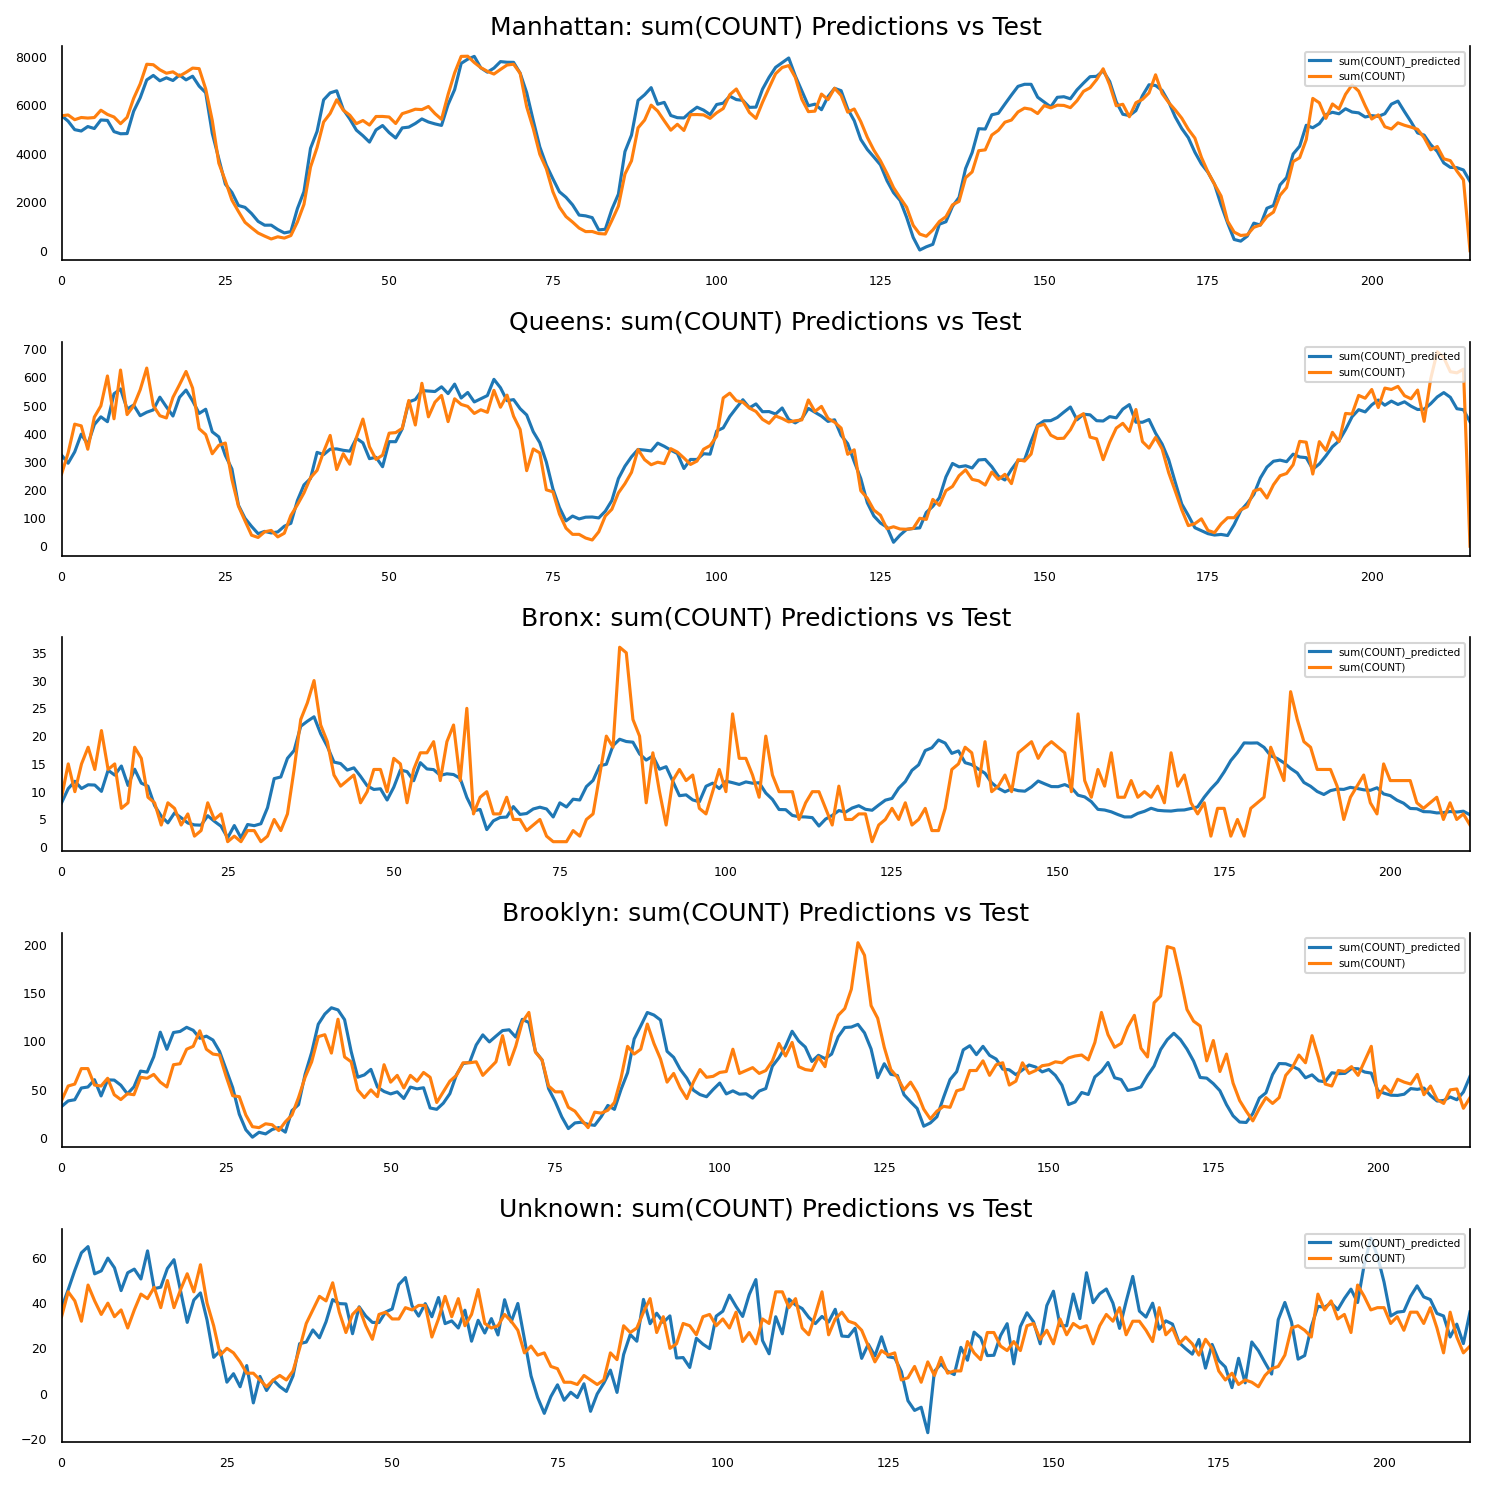

In [0]:
# PLOT RESULTS
def plot_time(predicted,test,divs):
  df_results = predicted[0].reset_index().drop(columns=["index"])
  df_test = test[0].reset_index().drop(columns=["index"])
  fig, axes = plt.subplots(nrows=int(len(test)), ncols=1, dpi=150, figsize=(10,10))
  for i, (df,ax) in enumerate(zip(divs, axes.flatten())):
      df_results = predicted[i].reset_index().drop(columns=["index"])
      df_test = test[i].reset_index().drop(columns=["index"])
      df_results['sum(COUNT)_predicted'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
      df_test['sum(COUNT)'].plot(legend=True, ax=ax);
      ax.set_title(divs[i]+ ": sum(COUNT) Predictions vs Test")
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      ax.legend(loc='upper right', fontsize=5)

  plt.tight_layout();
  
plot_time(div_predicted,test_dfs,divs)

<h1>Big Data Approach

Define Split, Train and Predict Functions

In [0]:

def VAR_build_model(partition):
  """
  Tune Vector Autoregressive (VAR)
  model and train it on dataframe.
  Returns the forecasted dataframe.
  """
  # Import Libraries
  from statsmodels.tsa.api import VAR
  import pandas as pd
  from sklearn.metrics import mean_absolute_percentage_error
  
  # Get number of observations from broadcasted dictionary
  n = counts.value
  nobs = n[partition.loc[1]['Division']]
  #numLags = 144
  #if partition.loc[1]['Division'] == "Unknown":
  #  numLags = 1680
  
  X_train = partition.drop("Division",axis=1)

  # HyperParameter Tuning
  numLags = findlags_map(X_train)

  # Define Model 
  model = VAR(X_train)
  
  # Fit and specify Lag order
  model_fitted = model.fit(numLags)
  lag_order = model_fitted.k_ar

  # Input data for forecasting
  forecast_input = X_train.values[-lag_order:]
  
  # Forecast 
  fc = model_fitted.forecast(y=forecast_input, steps=nobs)
  predicted = pd.DataFrame(fc, columns=X_train.columns + '_predicted')
  return predicted









# Define Schema for Pandas UDF
schema = StructType([
        StructField("Division", StringType(), True),
        StructField("avg(Duration)", DoubleType(), True),
        StructField("avg(Speed)", DoubleType(), True),
        StructField("avg(trip_distance)", DoubleType(), True),
        StructField("avg(total_amount)", DoubleType(), True),
        StructField("sum(COUNT)", DoubleType(), True)
    ])

# Split Data
@pandas_udf(schema,PandasUDFType.GROUPED_MAP)
def trainSplit(df):
  nobs = round(0.05*len(df))
  df_train = df[0:-nobs]
  return df_train

@pandas_udf(schema,PandasUDFType.GROUPED_MAP)
def testSplit(df):
  nobs = round(0.05*len(df))
  df_test = df[-nobs:]
  return df_test


# Create train and test dataset
train = taxi_clean.groupby().apply(trainSplit)
test = taxi_clean.groupby().apply(testSplit)


#train.show(10)
#test.show(10)

Now,
* Convert dataframe into RDDs and parallelise by Division
* Create pandas dataframe of data present in each partition
* Broadcast test data count of each division
* Train and Predict

In [0]:
train = taxi_clean.groupby().apply(trainSplit)
test = taxi_clean.groupby().apply(testSplit)

columns = train.columns
test_rdd = test.rdd.map(lambda x: (x.Division,x)).partitionBy(5,custom_partitioner)\
                          .map(lambda x: x[1])

test_parts = test_rdd.mapPartitions(toPandas_partition).collect()

c = dict()
for part in test_parts:
  c[part.loc[1]['Division']] = len(part)

counts = sc.broadcast(c)


train_rdd = train.rdd.map(lambda x: (x.Division,x))\
                     .partitionBy(5,custom_partitioner)\
                     .map(lambda x: x[1]).cache()


train_rdd.take(2)

Out[11]: [Row(Division='Unknown', avg(Duration)=12.685227272727277, avg(Speed)=11.43840909090909, avg(trip_distance)=2.4475, avg(total_amount)=15.218295454545443, sum(COUNT)=88.0),
 Row(Division='Unknown', avg(Duration)=13.614958677685948, avg(Speed)=12.320165289256202, avg(trip_distance)=2.7375206611570233, avg(total_amount)=15.351900826446256, sum(COUNT)=121.0)]

In [0]:
start = time.time()

VAR_predictions = train_rdd.mapPartitions(toPandas_partition).map(VAR_build_model).collect()

end = time.time()

bd_time = end - start

print("Time Taken: ",bd_time)

Time Taken: 92.52534484863281

In [0]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
def evaluation_metrics(predicted, test):
    mape = mean_absolute_percentage_error(predicted["sum(COUNT)_predicted"], test["sum(COUNT)"])
    return({'mape':mape})

evals = []
for i in range(len(test_parts)):
  evals.append(evaluation_metrics(VAR_predictions[i], test_parts[i].drop("Division",axis=1)))
i=0 
for a,e in enumerate(evals):
  print(test_parts[a].loc[1]['Division'])
  i+=1
  for k, v in e.items():
      print(k, ': ', round(v,4))
      

Unknown
mape : 0.8533
Manhattan
mape : 0.2415
Queens
mape : 0.1779
Bronx
mape : 0.433
Brooklyn
mape : 0.3741

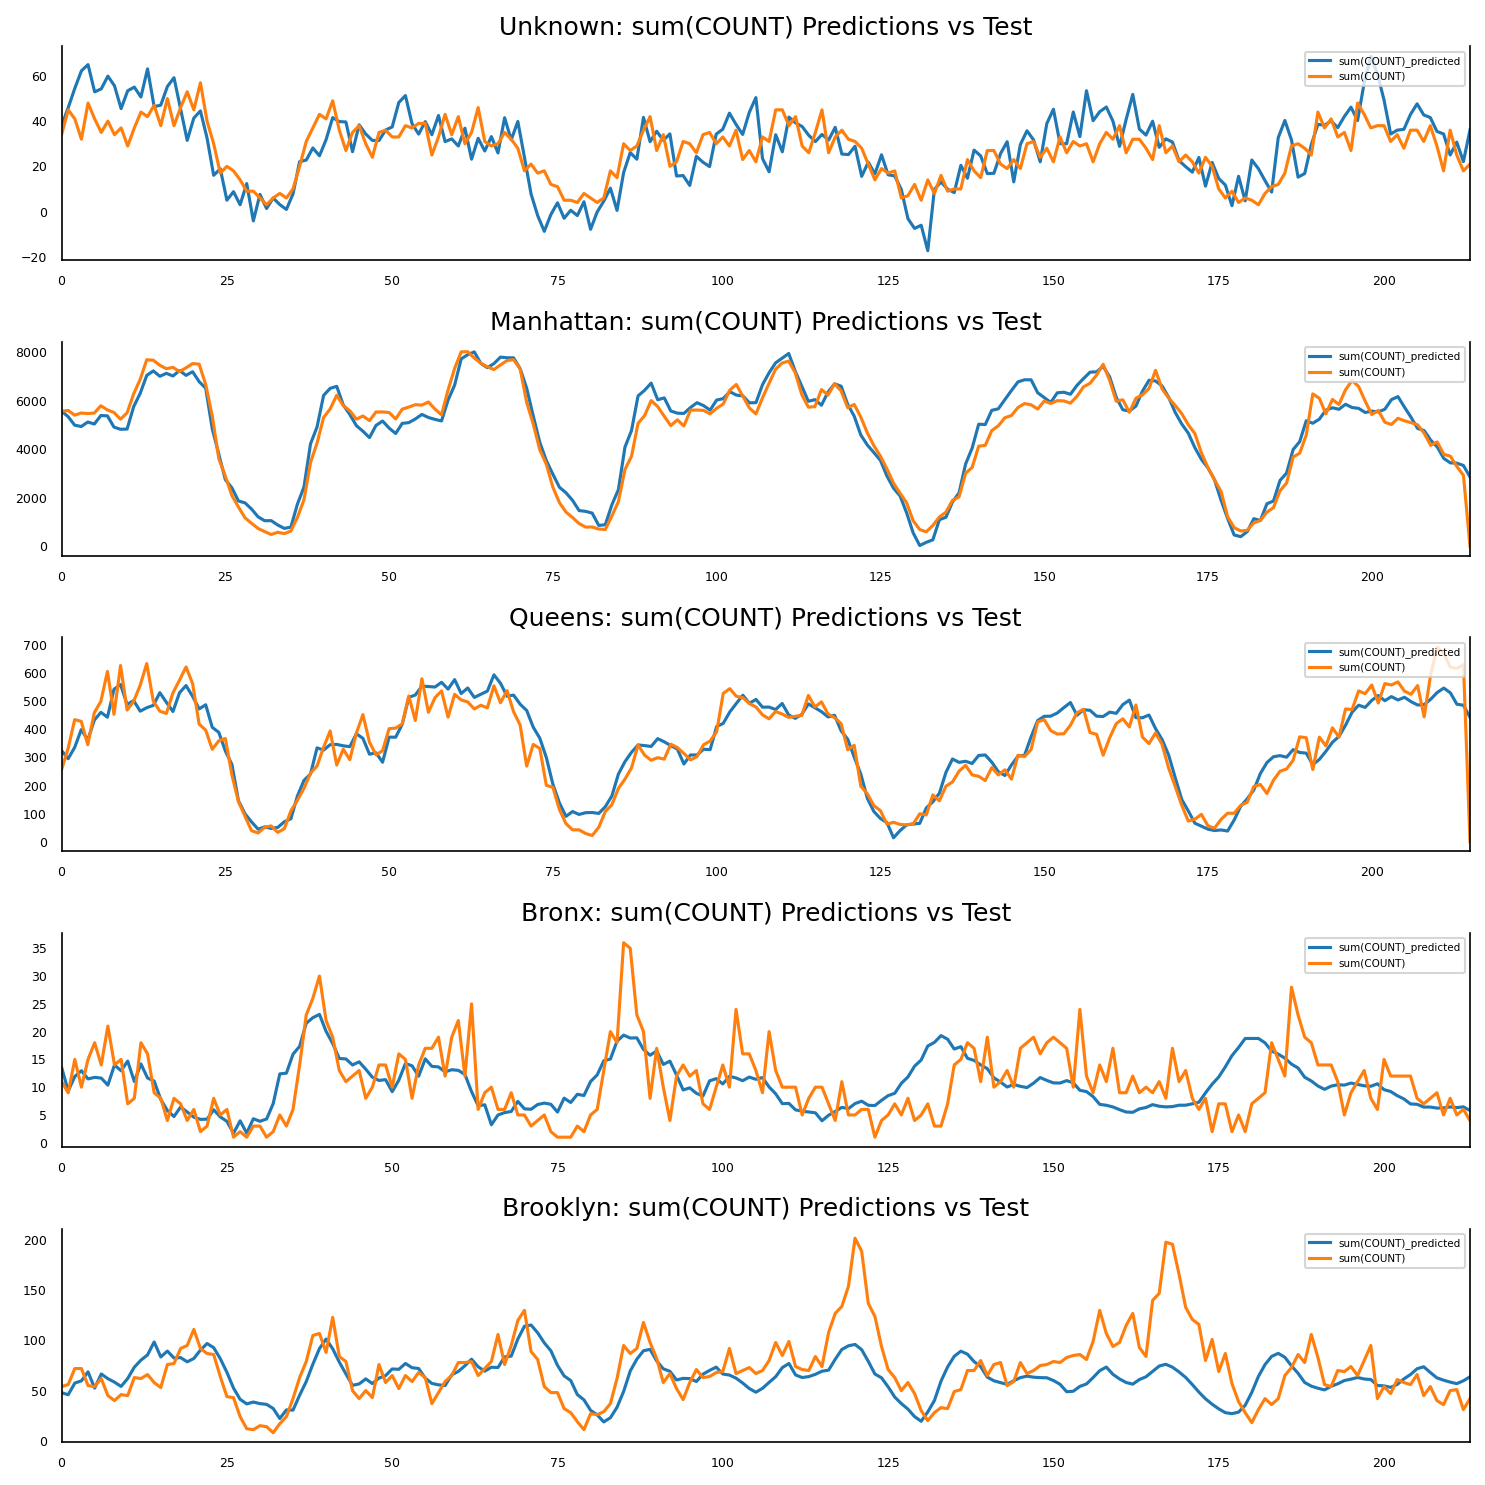

In [0]:
divs = ["Unknown", "Manhattan","Queens","Bronx","Brooklyn" ]

df_results = VAR_predictions[0].reset_index().drop(columns=["index"])
df_test = test_parts[0].reset_index().drop(columns=["index"])
fig, axes = plt.subplots(nrows=int(len(df_test.columns))-1, ncols=1, dpi=150, figsize=(10,10))
for i, (df,ax) in enumerate(zip(divs, axes.flatten())):
    df_results = VAR_predictions[i].reset_index().drop(columns=["index"])
    df_test = test_parts[i].reset_index().drop(columns=["index"])
    df_results['sum(COUNT)_predicted'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test['sum(COUNT)'].plot(legend=True, ax=ax);
    ax.set_title(divs[i]+ ": sum(COUNT) Predictions vs Test")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper right', fontsize=5)
plt.tight_layout();

In [0]:

x = PrettyTable()

x.add_column("Sequential",[seq_time])
x.add_column("Big Data", [bd_time])

print(x)

+--------------------+-------------------+
 Sequential | Big Data |
+--------------------+-------------------+
 358.34167408943176 | 92.52534484863281 |
+--------------------+-------------------+